<a href="https://colab.research.google.com/github/uzeziogho/Kaggle-competitions/blob/main/DisasterTweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
#Import libraries
!pip install apyori
!pip install xlrd
!pip install utils
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
#import libraries
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
nltk.download(['stopwords','punkt','wordnet','omw-1.4','vader_lexicon'])
%matplotlib inline
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [49]:
# test tokenizer
simple_text="This coursework is taking a whole load of time!"

In [50]:
#create a tokenizer
tokenizer=nltk.tokenize.RegexpTokenizer('[a-zA-Z0-9\']+')
tokenized_document=tokenizer.tokenize(simple_text)
print(tokenized_document)

['This', 'coursework', 'is', 'taking', 'a', 'whole', 'load', 'of', 'time']


In [51]:
stop_words=nltk.corpus.stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [52]:
#Remove stopwords
cleaned_tokens=[]

for word in tokenized_document:
  word=word.lower()
  if word not in stop_words:
    cleaned_tokens.append(word)

print(cleaned_tokens)

['coursework', 'taking', 'whole', 'load', 'time']


In [53]:
cleaned_words=[word.lower() for word in tokenized_document if word.lower() not in stop_words]
print(cleaned_tokens)

['coursework', 'taking', 'whole', 'load', 'time']


In [55]:
#lemmatization and stemming process
lemmatizer=nltk.stem.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()

words=['cacti','sings','hopped','rocks','better','easily']
pos=['n','v','v','n','a','r']

lemmatized_words=[lemmatizer.lemmatize(words[i],pos=pos[i])for i in range(6)]
stemmed_words=[stemmer.stem(word)for word in words]

print("Lemmatized words:",lemmatized_words)
print("Stemmed words:",stemmed_words)

Lemmatized words: ['cactus', 'sing', 'hop', 'rock', 'good', 'easily']
Stemmed words: ['cacti', 'sing', 'hop', 'rock', 'better', 'easili']


In [56]:
stemmed_text=[stemmer.stem(word) for word in cleaned_tokens]

print(stemmed_text)

['coursework', 'take', 'whole', 'load', 'time']


In [57]:
#Function for data processing steps for corpus
def preprocess_text(text):
  tokenized_document=nltk.tokenize.RegexpTokenizer('[a-zA-Z0-9\']+').tokenize(text)
  cleaned_tokens=[word.lower()for word in tokenized_document if word.lower()not in stop_words]
  stemmed_text=[nltk.stem.PorterStemmer().stem(word)for word in cleaned_tokens]
  return stemmed_text

In [44]:
# Assuming you have a dataset with labeled tweets where 1 represents a real disaster and 0 represents not a disaster_
train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')

In [48]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [36]:
# Define disaster-related keywords
#disaster_keywords = ['earthquake', 'fire', 'flood', 'emergency', 'Disaster','Catastrophe','Crisis','Tragedy','Devastation','Destruction','Calamity',
                    # 'Hazard','Cataclysm','Accident','Earthquake','Hurricane','Tornado','Tsunami','Drought','Epidemic','Outbreak','Explosion','Collapse',
                     #'Evacuation','Rescue','Suffering','Casualty','Damage','Recovery','Relief','Aid','Shelter','quarantine','evacuated','collapse','wild fire']

Text(0, 0.5, 'Samples')

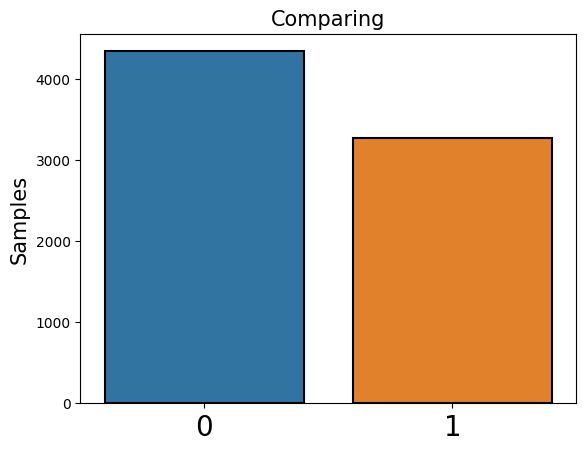

In [59]:
target=train_data['target'].value_counts()
sns.barplot(x=target.index,y=target,edgecolor=(0,0,0),linewidth=1.5)
plt.title('Comparing',fontsize=15)
plt.xticks(fontsize=20)
plt.ylabel('Samples',fontsize=15)

In [61]:
def lower(words):
    return words.lower()
train_data['text']=train_data['text'].apply(lambda x:lower(x))

In [62]:
def remove_numbers(words):
    return re.sub(r'\d+','',words)
train_data['text']=train_data['text'].apply(lambda x: remove_numbers(x))

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect=TfidfVectorizer(min_df=2
                      ,max_features = None,analyzer="word",  ngram_range=(1,3) # (1,6)
                           ).fit(train_data['text'])
x_train_vect=vect.transform(train_data['text'])

In [67]:
# Perform SMOTE oversampling on the training data
from imblearn.over_sampling import SMOTE
smote = SMOTE()
train_features_oversampled, train_target_oversampled = smote.fit_resample(x_train_vect, train_data['target'])

In [68]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(train_features_oversampled, train_target_oversampled)

LogisticRegression()

In [69]:
predictions=model.predict(vect.transform(test_data['text']))

In [70]:
predictions

array([1, 0, 1, ..., 1, 1, 1])

In [72]:
sample_submission_df=pd.read_csv('/content/sample_submission.csv')
sample_submission_df['target']=predictions

In [73]:
sample_submission_df

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [74]:
# Save the DataFrame to a CSV file
sample_submission_df.to_csv('sample_submission.csv', index=False)